# Capstone Project: 
# Reduce Cyberbullying via Curbing of Toxic Comments

## Problem Statement

Given an accurately labelled dataset of toxic comments, the task is to determine if a given comment is considered offensive to another person.

## Executive Summary
---
### Contents:
- [Data Gathering](#Data-Gathering)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Data Gathering

We will be using the dataset from the following Kaggle competition:

[Jigsaw Unintended Bias in Toxicity Classification](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data)

## Data Cleaning & EDA

In [16]:
import pandas as pd
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, AdaBoostClassifier
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk.corpus import stopwords # Import the stop word list
import sys 
from textblob import TextBlob, Word
from nltk.corpus import wordnet as wn
from sklearn.utils import resample

pd.set_option('display.max_rows', 100) # to look at more rows of data later
pd.set_option('display.max_columns', 100) # to expand columns view so that all can be seen later

You can refer to the following [notebook](./Cleaning.ipynb) for information of the cleaning process.

In [17]:
# Load the cleaned dataset from csv.

cleaned_text_df = pd.read_csv('../dataset/cleaned_text_df.csv')

Displaying wordclouds and bar graphs to get a sense of the words for the various labels.

In [4]:
def show_wordcloud(data, title):
    """
    Display wordcloud based on the data given.
    
    Parameters
    ----------
    data: list[str]
        List of string text that is to be shown in the word cloud
        
    title: str
        Prints the title of the word cloud
    """
    wordcloud = WordCloud(
       background_color='white',
       max_words=1000,
       colormap='brg',
       scale=3).generate(str(data))
    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
            

In [5]:
def gen_wordcloud(data):
    """
    Display wordcloud based on the data given.
    
    Parameters
    ----------
    data: list[str]
        List of string text that is to be shown in the word cloud
        
    title: str
        Prints the title of the word cloud
    """
    wordcloud = WordCloud(
       background_color='white',
       max_words=100,
       colormap='brg',
       scale=3).generate(str(data))
    return wordcloud
    

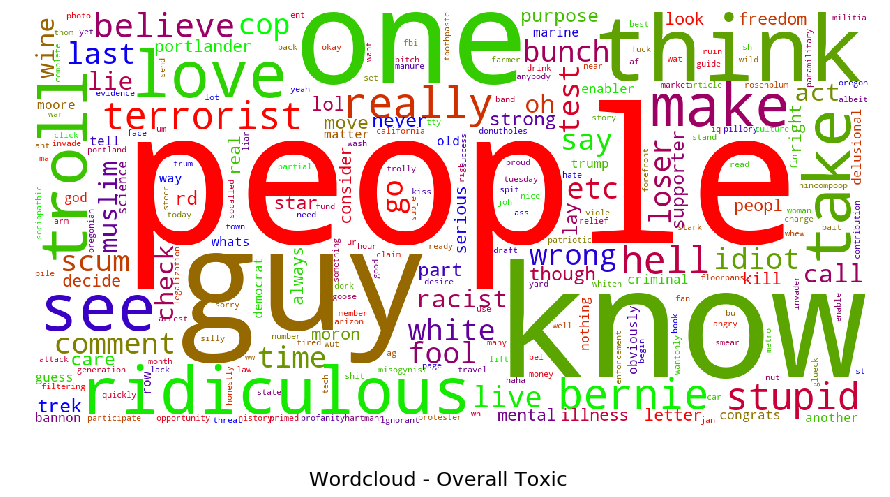

In [8]:
show_wordcloud(cleaned_text_df[cleaned_text_df['target'] >= 0.5][['comment']],'Wordcloud - Overall Toxic')

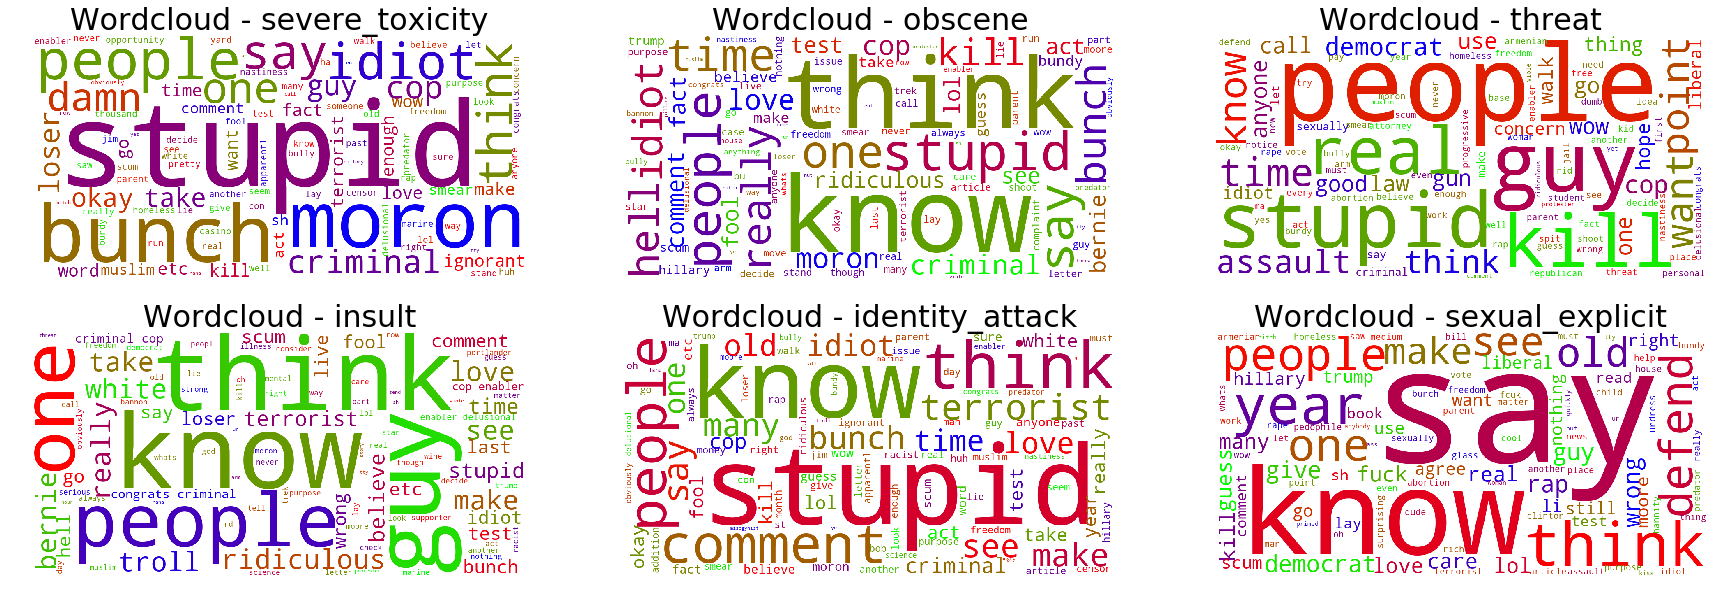

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,10)) 
toxic_labels = ['severe_toxicity','obscene','threat','insult','identity_attack','sexual_explicit']
ax = ax.ravel()
for i, column in enumerate(toxic_labels):
    wordcloud = gen_wordcloud(cleaned_text_df[(cleaned_text_df['target'] >= 0.5) & (cleaned_text_df[column] > 0)][['comment']])
    ax[i].set_title('Wordcloud - '+toxic_labels[i],fontsize=30)
    ax[i].imshow(wordcloud)
    ax[i].axis('off')
# plt.tight_layout()


From the wordclouds, we can see that some of the words are relatively common across different groups (know, think).

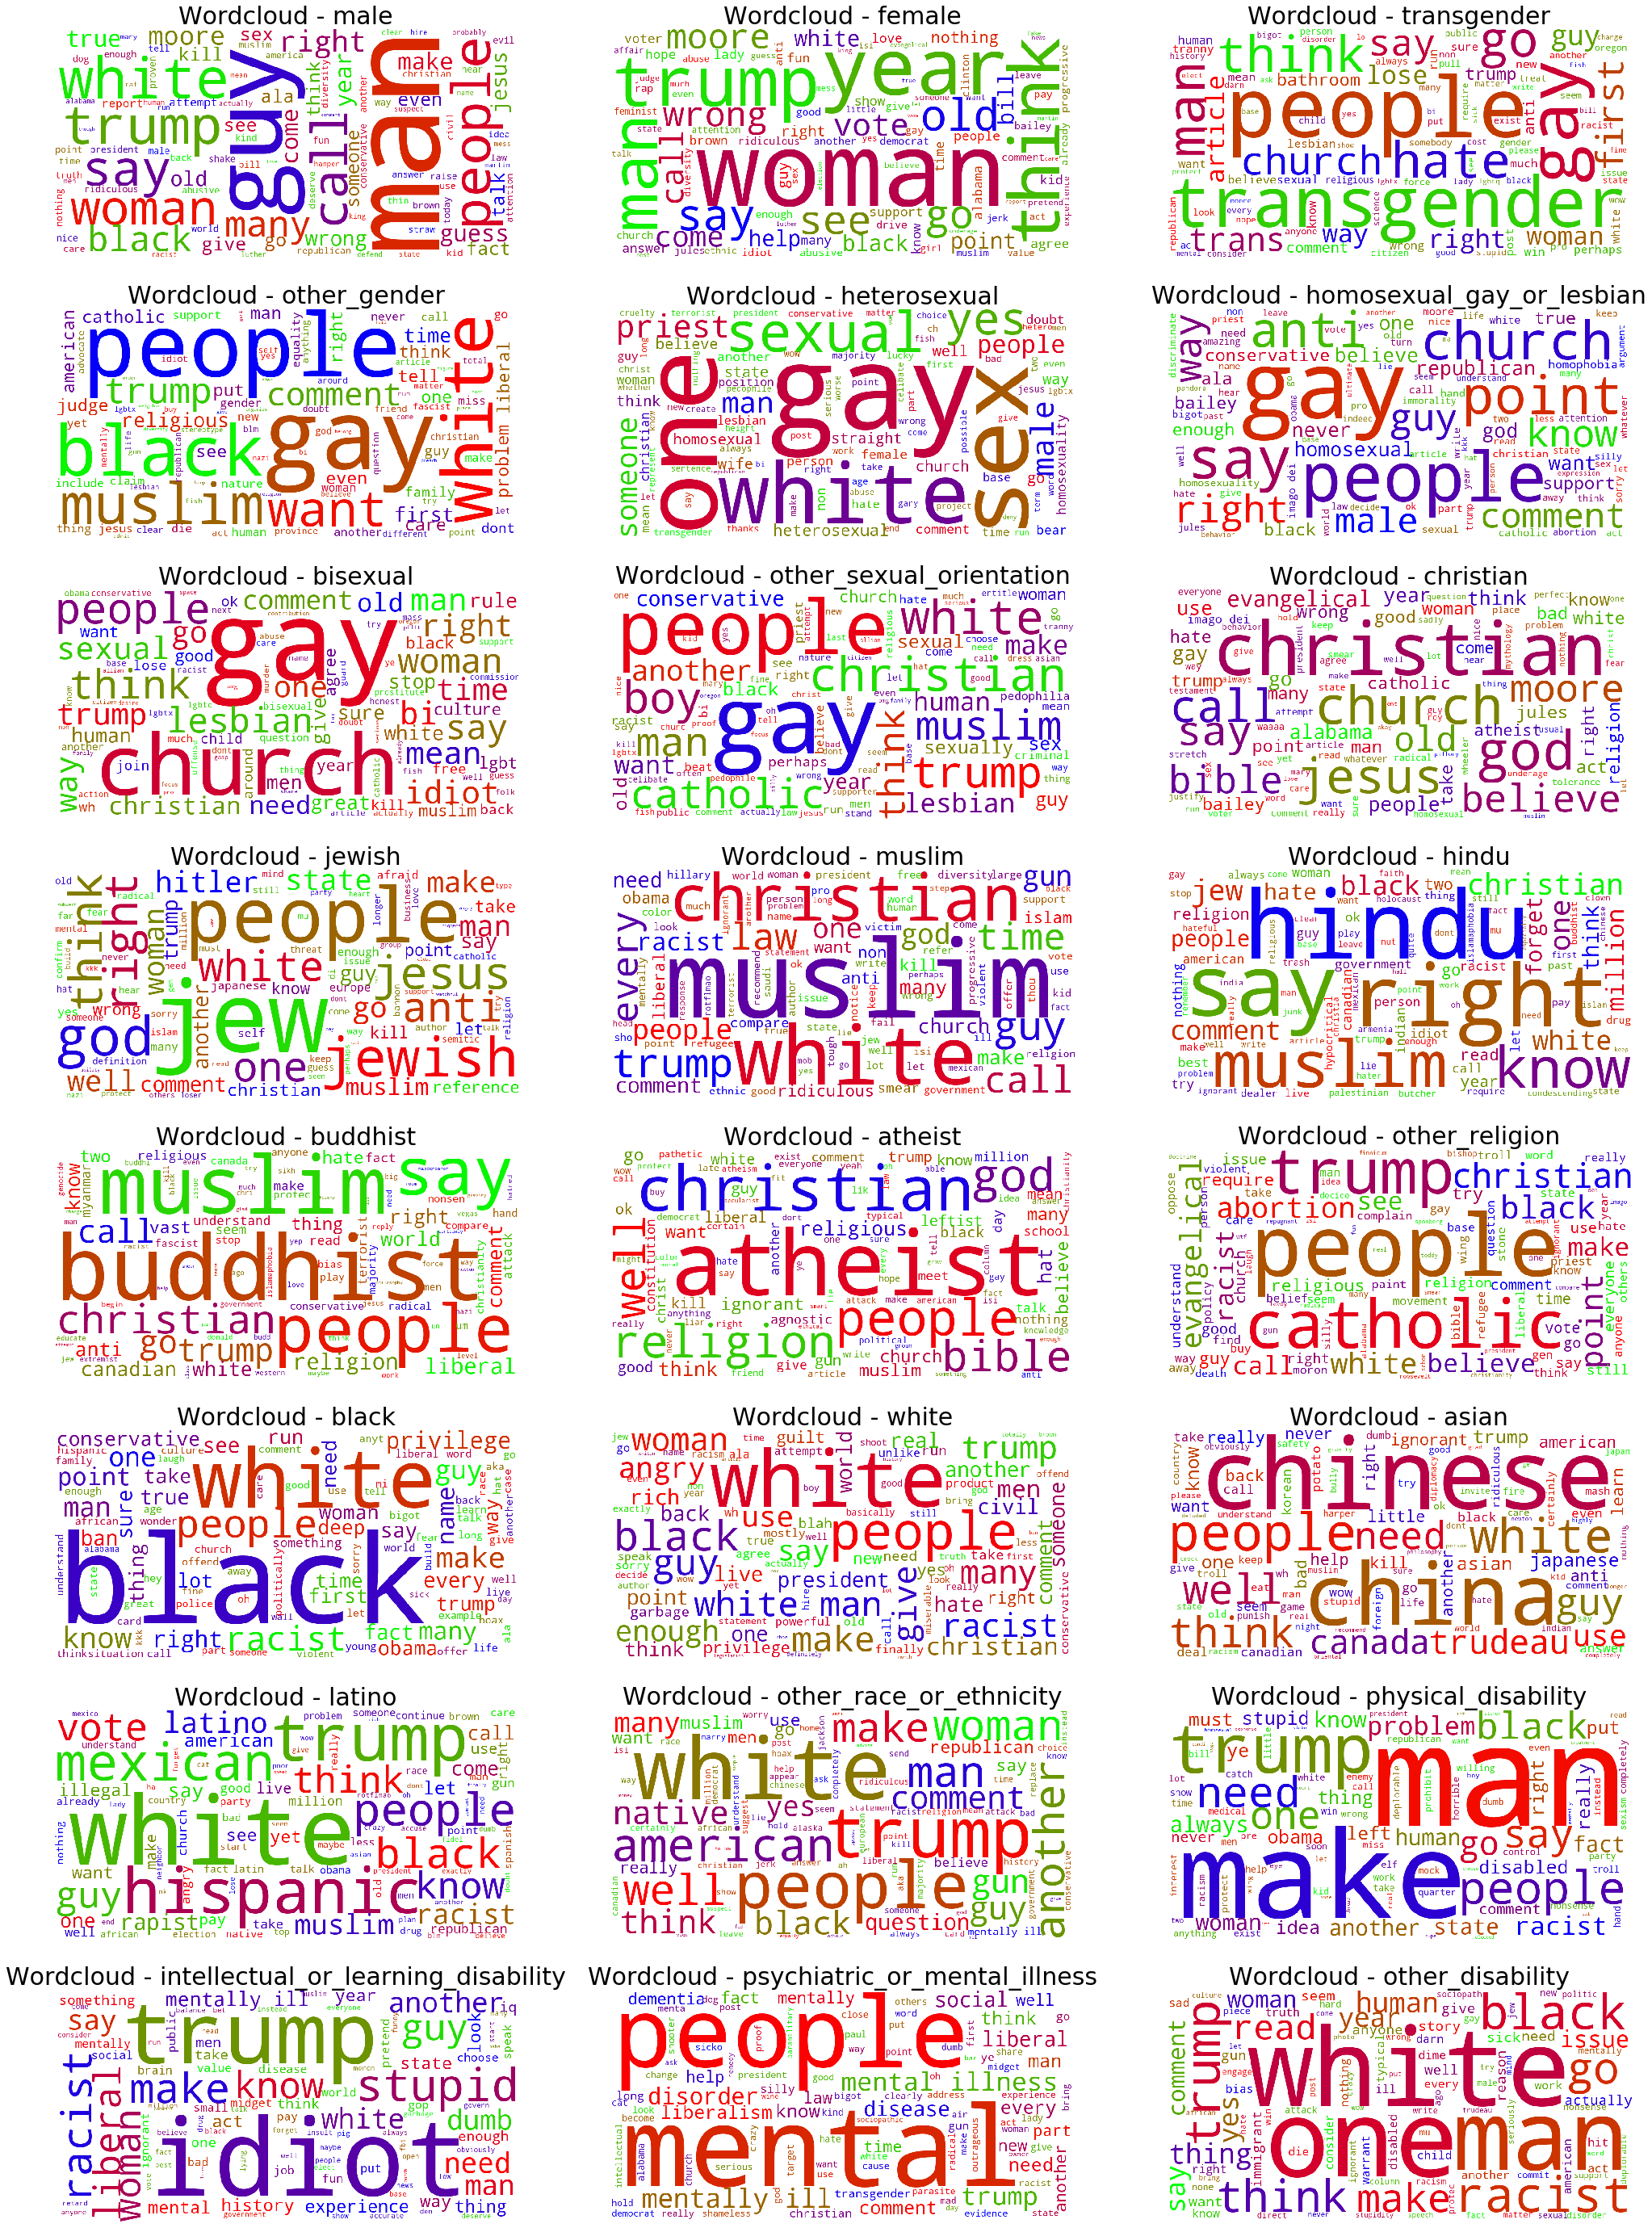

In [29]:
identity_labels = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian','bisexual','other_sexual_orientation',
                   'christian','jewish','muslim','hindu','buddhist','atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
                   'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness','other_disability']

fig, ax = plt.subplots(nrows=round(len(identity_labels)/3), ncols=3, figsize=(35,50)) 
ax = ax.ravel()
for i, column in enumerate(identity_labels):
    wordcloud = gen_wordcloud(cleaned_text_df[(cleaned_text_df['target'] >= 0.5) & (cleaned_text_df[column] > 0)][['comment']])
    ax[i].set_title('Wordcloud - '+identity_labels[i],fontsize=30)
    ax[i].imshow(wordcloud)
    ax[i].axis('off')

In [18]:
cleaned_text_df['target'] = [1 if i >= 0.5 else 0 for i in cleaned_text_df['target']]

In [19]:
cleaned_text_df['target'].value_counts()

0    1638959
1     123454
Name: target, dtype: int64

As seen above, our classes are greatly imbalanced, so we will downsample the majority class to get a more balanced dataset.

In [20]:
# Separate majority and minority classes
df_majority = cleaned_text_df[cleaned_text_df['target']==0]
df_minority = cleaned_text_df[cleaned_text_df['target']==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=round(df_minority.shape[0]*6/5),     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['target'].value_counts()
# Name: balance, dtype: int64

0    148145
1    123454
Name: target, dtype: int64

## Preprocessing and Modeling

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_downsampled['comment'],
                                                    df_downsampled['target'],
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=df_downsampled['target'])

In [22]:
model_dict = {
    'cvec': CountVectorizer(),
    'tvec': TfidfVectorizer(),
    'lr': LogisticRegression(solver='lbfgs'),
    'knn': KNeighborsClassifier(),
    'nb': MultinomialNB(),
    'rf': RandomForestClassifier(),
    'et': ExtraTreesClassifier(),
    'ada': AdaBoostClassifier(random_state=42)
}

model_full = {
    'cvec': 'CountVectorizer',
    'tvec': 'TfidfVectorizer',
    'lr': 'Logistic Regression',
    'knn': 'KNearestNeighbor',
    'nb': 'Multinomial NB',
    'dt': 'Decision Tree',
    'rf': 'Random Forest',
    'et': 'Extra Tree',
    'ada': 'AdaBoost'
}

param_dict = {
    'cvec': {
        'cvec__max_features': [5000,6000,7000],
        'cvec__min_df': [3,4],
        'cvec__max_df': [.9, .95],
        'cvec__ngram_range': [(1,1), (1,2)]
    },
    'tvec': {
        'tvec__max_features': [5000,6000,7000],
        'tvec__min_df': [3,4],
        'tvec__max_df': [.9, .95],
        'tvec__ngram_range': [(1,1), (1,2)]
    },
    'knn': {
        'knn__n_neighbors': [5,6,7,8,9]
    },
    'lr': {},
    'nb': {},
    'dt': {
        'dt__max_depth': [5,7],
        'dt__min_samples_split': [10,15],
        'dt__min_samples_leaf': [3,4]
    },
    'rf': {
        'rf__n_estimators': [100],
        'rf__max_depth': [5,7],
        'rf__min_samples_split': [10,15],
        'rf__min_samples_leaf': [3,4]
        
    },
    'et': {
        'et__n_estimators': [100],
        'et__max_depth': [5,7],
        'et__min_samples_split': [10,15],
        'et__min_samples_leaf': [3,4]
    },
    'ada': {
        'ada__n_estimators': [50,100,200],
        'ada__learning_rate': [0.9, 1]
    }
}

def prepare_pipeline(list_of_models):
    """
    Prepare pipeline of models to be used for modelling
    
    Parameters
    ----------
    list_of_models: list[str]
        List of models to be included for pipeline
    
    Returns
    -------
    Pipeline
        Pipeline of models to be run
    """
    pipe_list = [(i,model_dict[i]) for i in list_of_models]
    return Pipeline(pipe_list)

def add_params(name,pipe_dict):
    """
    Add parameters for GridSearch
    
    Parameters
    ----------
    name: str
        Name of model/vectorization method to have params added.
    pipe_dict: Dictionary
        Dictionary that contains parameters to be added into GridSearch
    
    Returns
    -------
    Dictionary
        Dictionary that contains parameters to be added for GridSearch
    """
    params = param_dict[name]
    for k,v in params.items():
        pipe_dict[k] = v
    return pipe_dict

def grid_search(vec_method,model,filename,X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test):
    """
    Initialize and run GridSearch
    
    Parameters
    ----------
    vec_method: str
        Vectorization method to use. Vectorization method has to be contained in model_dict.
        
    model: str
        Initialize which classification model to use. Note classification model has to be contained in model_dict.
        
    filename: str
        Name of pickle file to save to.
        
    X_train: list[str]
        List of training data to be used
        
    y_train: list[str]
        Target value of the training data
        
    X_test: list[str]
        List of test data to be used 
        
    y_test: list[str]
        Target value of test data
    
    Returns
    -------
    List
        List that contains predicted values of the test data
    """
    pipe_params = {}
    pipe_params = add_params(vec_method,pipe_params)
    pipe_params = add_params(model,pipe_params)
    pipe = prepare_pipeline([vec_method,model])
    gs = GridSearchCV(pipe,param_grid=pipe_params,cv=3,n_jobs=3,scoring='recall')
    gs.fit(X_train,y_train)
    print(f'Using {model_full[model]} with {model_full[vec_method]}:')
    print(f'Train Score: {round(gs.best_score_,4)}')
    print(f'Test Score: {round(gs.score(X_test,y_test),4)}')
    print(f'Using the following parameters: {gs.best_params_}')
    # Save model into pickle
    pickle.dump(gs, open(filename, 'wb'))
    return gs.best_estimator_.predict(X_test)

In [23]:
cvec_nb_predictions = grid_search('cvec','nb','cvec_nb.sav')

Using Multinomial NB with CountVectorizer:
Train Score: 0.8431
Test Score: 0.8504
Using the following parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 7000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}


In [24]:
tvec_lr_predictions = grid_search('tvec','lr','tvec_lr.sav')

C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Using Logistic Regression with TfidfVectorizer:
Train Score: 0.7878
Test Score: 0.7976
Using the following parameters: {'tvec__max_df': 0.9, 'tvec__max_features': 7000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}


In [25]:
cvec_lr_predictions = grid_search('cvec','lr','cvec_lr.sav')

C:\Users\Carol\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Using Logistic Regression with CountVectorizer:
Train Score: 0.7839
Test Score: 0.7894
Using the following parameters: {'cvec__max_df': 0.9, 'cvec__max_features': 7000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1)}


## Evaluation and Conceptual Understanding 

We get the classificaition report of the following to evaluate the models.

In [26]:
print(classification_report(y_test, cvec_nb_predictions, target_names=['non-toxic','toxic']))

              precision    recall  f1-score   support

   non-toxic       0.85      0.72      0.78     37036
       toxic       0.72      0.85      0.78     30864

    accuracy                           0.78     67900
   macro avg       0.79      0.79      0.78     67900
weighted avg       0.79      0.78      0.78     67900



In [27]:
print(classification_report(y_test, tvec_lr_predictions, target_names=['non-toxic','toxic']))

              precision    recall  f1-score   support

   non-toxic       0.84      0.90      0.87     37036
       toxic       0.87      0.80      0.83     30864

    accuracy                           0.86     67900
   macro avg       0.86      0.85      0.85     67900
weighted avg       0.86      0.86      0.85     67900



In [28]:
print(classification_report(y_test, cvec_lr_predictions, target_names=['non-toxic','toxic']))

              precision    recall  f1-score   support

   non-toxic       0.84      0.90      0.87     37036
       toxic       0.87      0.79      0.83     30864

    accuracy                           0.85     67900
   macro avg       0.85      0.85      0.85     67900
weighted avg       0.85      0.85      0.85     67900



Looking at the 3 different models, I will opt to use Logistic Regression with TFIDF-Vectorizer, as the recall score is much more balanced across both classification, and the f1-score is higher. Even though the likelihood of getting a false negative is higher using this model as compared to using Multinomial NB with COuntVectorizer, the amount of comments that are classified to false positive are greatly reduced.

Next, using purely the toxic comments as the dataset, we will use it to train a model to do a multi-label classification.

In [14]:
# Filter out the toxic comments
df_positive = df_minority
df_positive.fillna(0,inplace=True)

C:\Users\Carol\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [15]:
# Store it into a csv
df_positive.to_csv('../dataset/positiveset.csv',index=False)

The modelling of the multi-label classification can be found in this [notebook](./MultiLabel.ipynb).

## Conclusion and Recommendations

The binary classification of toxic comments work well when we under-sample the non-toxic comments and using Logistic Regression with TDIDF-Vectorizer. The multi-label classification was able to classify insult comments accurately but having rather mixed results when assigning the remaining labels.

For this capstone project, we are limited by the following areas:
- Hardware of machine used
- Time factor (6 weeks)
- Budget limitation

We can further expand the scope of the project to include the following:
- Applying deep learning to perform unsupervised learning
- Gather more data on toxic comments with more related labels
- Expand the multi-label classification to identity labels
